In [130]:
from Evolution import *
import random

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd 

from tqdm import tqdm

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [131]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True).frame
data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [132]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
class MyChromosome(BaseChromosome):
    def __init__(self):
        super().__init__()

    def crossover(self, other):
        new = MyChromosome()
        self.copy(new)

        new['depth'] = (self['depth'] + other['depth']) // 2

        new['learning_rate'] = random.choice([self['learning_rate'], other['learning_rate']])

        return new

    def mutate(self, rate=0.3):
        new = MyChromosome()
        self.copy(new)

        if random.random() < rate:
            new.depth = new._depth.get()
        else:
            new.depth = self.depth

        if random.random() < rate:
            new.learning_rate = new._learning_rate.get()
        else:
            new.learning_rate = self.learning_rate
        return new

chromosome_factory = ChromosomeClassFactory(
        depth=list(range(4, 11)),
        learning_rate=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
    )

In [134]:
def evaluate_model(chromosome, show_metric=False):
    n_iterations = 4
    metric = 0
    for _ in range(n_iterations):
        model = CatBoostClassifier(iterations=100, depth=chromosome.depth, learning_rate=chromosome.learning_rate, verbose=False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        metric += accuracy_score(y_test, y_pred)
    metric /= n_iterations

    if show_metric:
        print(f'{metric=}')

    return metric

In [135]:
# evolution hyperparameters initialisation 
POPULATION_SIZE = 30
ITERATIONS = 100
best = [None, -float('inf')]

In [136]:
# need for statistic collection 
statistic_best = []
statistic_mean = []

statistic_depth = []
statistic_learning_rate = []

# Evolutionary algorithm 

# initial population initialisation 
population = []
for _ in range(POPULATION_SIZE):
    c = chromosome_factory.generate(MyChromosome)
    population.append([c, None])

# evolution process 
for _ in tqdm(range(ITERATIONS)):
    # scoring each chromosome 
    for instance in population:
        if instance[1] is None:
            instance[1] = evaluate_model(instance[0])

    # selection of best instances 
    population = sorted(population, key=lambda x: x[1], reverse=True)[:POPULATION_SIZE // 3]

    statistic_best.append(population[0][1])
    statistic_mean.append(sum(map(lambda x: x[1], population)) / POPULATION_SIZE)

    statistic_depth.append(population[0][0].depth)
    statistic_learning_rate.append(population[0][0].learning_rate)

    # checking for the best solution 
    if population[0][1] > best[1]:
        best = population[0]

    # filling the population with new genes 
    while len(population) < POPULATION_SIZE:
        r = random.random()
        if r < 0.33:
            population.append([random.choice(population)[0].crossover(random.choice(population)[0]), None])
        elif 0.33 <= r < 0.66:
            population.append([random.choice(population)[0].mutate(), None])
        else:
            population.append([chromosome_factory.generate(MyChromosome), None])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [2:40:45<00:00, 96.45s/it]  


In [137]:
print(best[0], f'{best[1]:_}', sep='\n')
evaluate_model(best[0], True)
None

--Chromosome--
depth: 6
learning_rate: 0.07

0.9736842105263158
metric=0.9736842105263158


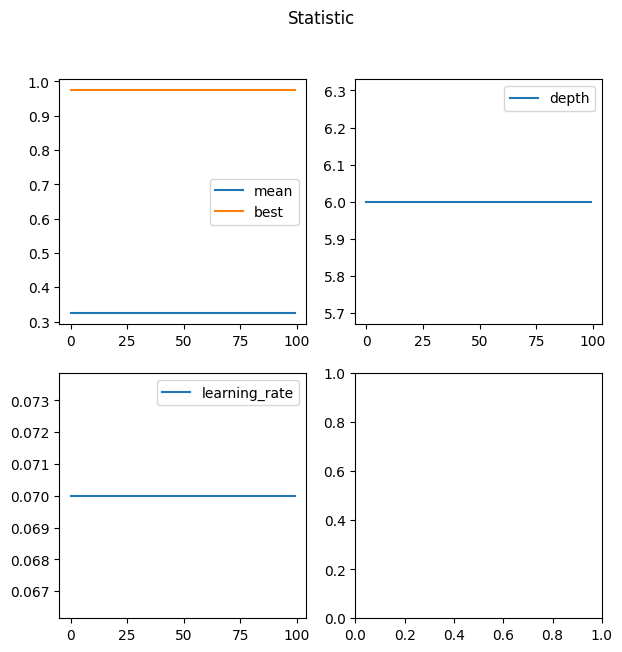

In [138]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
fig.suptitle('Statistic')

plt.subplot(2, 2, 1)
plt.plot(statistic_mean, label='mean')
plt.plot(statistic_best, label='best')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(statistic_depth, label='depth')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(statistic_learning_rate, label='learning_rate')
plt.legend()

plt.show()

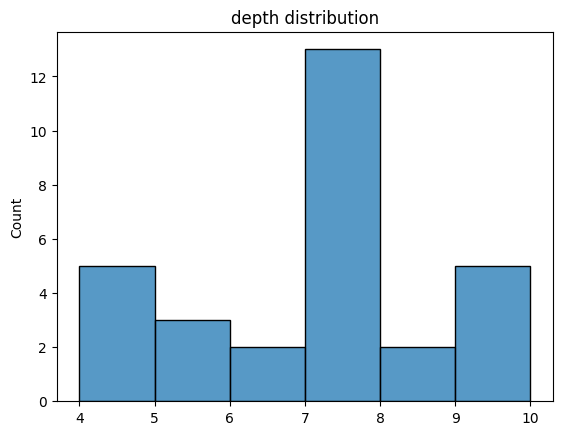

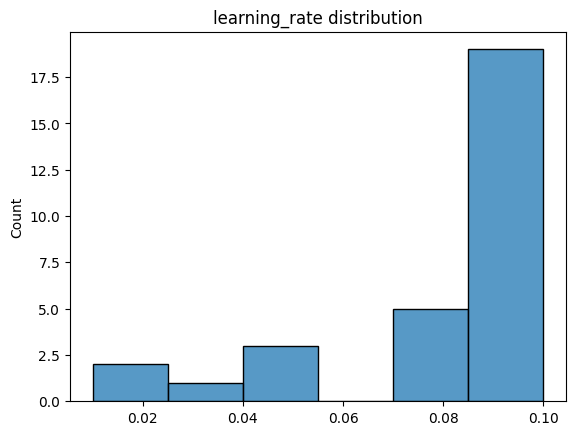

In [139]:
import seaborn as sns 

sns.histplot([c[0].depth for c in population])
plt.title('depth distribution')
plt.show()

sns.histplot([c[0].learning_rate for c in population])
plt.title('learning_rate distribution')
plt.show()